# Whisper Model
notebook by Sivan Ding (sd5397)

Whisper is a general-purpose speech recognition model. It is trained on a large dataset of diverse audio and is also a multi-task model that can perform multilingual speech recognition as well as speech translation and language identification.

Codes below adpated from [github repo](https://github.com/openai/whisper)

## Requirement
Python 3.9.9 and PyTorch 1.10.1

In [ ]:
!pip install colorednoise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Julia's code

import librosa
import numpy as np
import colorednoise as cn


def add_noise(s, sample_rate=16000, noise_percentage_factor = .01, noise_type='white'):
    # s: audio input (mono)
    # sample rate: sample rate of s
    # noise_percentage_factor, percentage scale of added noise added
    # type: white, pink, brown

    if noise_type == 'white':
        beta = 0

    elif noise_type == 'pink':
        beta = 1

    elif noise_type == 'brown':
        beta = 2

    noise = cn.powerlaw_psd_gaussian(beta, s.size)

    noisy_s = s + noise * noise_percentage_factor

    # output should be at 16kHz sample rate
    if sample_rate != 16000:
        noisy_s = librosa.resample(noisy_s, orig_sr = sample_rate, target_sr=16000)

    return noisy_s


def add_signals(s, back_s, sample_rate=16000, back_sample_rate=16000, noise_db=-12):
    # s: audio input (mono)
    # back_s: brckgrnd audio
    # sample rate: sample rate of s
    # noise_db: lower the backgrnd signal by noise_db db


    # make sure both signals have same 16kHz sample rate
    if sample_rate != 16000:
        s = librosa.resample(s, orig_sr=sample_rate, target_sr=16000)

    if back_sample_rate != 16000:
        back_s = librosa.resample(back_s, orig_sr=back_sample_rate, target_sr=16000)

    if s.size > back_s.size:
        back_s = librosa.util.pad_center(back_s, size=s.size)

    elif s.size < back_s.size:
        s = librosa.util.pad_center(s, size=back_s.size)

    # lower background signal by noise_db
    noise_amp = librosa.db_to_amplitude(noise_db)
    lower_back_s = back_s - noise_amp

    # add background noise to sound clip
    noisy_s = s + back_s

    # output should be at 16kHz sample rate
    return noisy_s


def down_sample(s, sample_rate=16000, output_sr=8000):
    # s: audio input (mono)
    # sample rate: sample rate of s
    # output_sr: output sample rate

    # resample to output_sr
    resampled_s = librosa.resample(s, orig_sr=sample_rate, target_sr=output_sr)

    # then re-resample to 16000
    noisy_s = librosa.resample(resampled_s, orig_sr=output_sr, target_sr=16000)

    # output should be at 16kHz sample rate
    return noisy_s

In [ ]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

In [ ]:
!pip install git+https://github.com/openai/whisper.git 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-jxbnydkz
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-jxbnydkz
     |████████████████████████████████| 5.3 MB 33.6 MB/s 
     |████████████████████████████████| 7.6 MB 78.2 MB/s 
     |████████████████████████████████| 163 kB 75.6 MB/s 
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1175147 sha256=b9a1bf55d3a666fd7dcc626881022662ae18ebb7c4a7556dc98fa134d11454f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2j7kvmbj/wheels/16/15/89/1c7bb31bd0006793a95549d04785121a8a36daad9158e1e43a
Successfully built whisper


**It also requires the command-line tool ffmpeg to be installed on your system, which is available from most package managers: (specifically for mac M1 arm64)**

In [ ]:
# install homebrew
!/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"
# install rust
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
# on MacOS using Homebrew (https://brew.sh/)
!brew install ffmpeg

==> Checking for `sudo` access (which may request your password)...
==> This script will install:
/home/linuxbrew/.linuxbrew/bin/brew
/home/linuxbrew/.linuxbrew/share/doc/homebrew
/home/linuxbrew/.linuxbrew/share/man/man1/brew.1
/home/linuxbrew/.linuxbrew/share/zsh/site-functions/_brew
/home/linuxbrew/.linuxbrew/etc/bash_completion.d/brew
/home/linuxbrew/.linuxbrew/Homebrew
==> The following new directories will be created:
/home/linuxbrew/.linuxbrew/bin
/home/linuxbrew/.linuxbrew/etc
/home/linuxbrew/.linuxbrew/include
/home/linuxbrew/.linuxbrew/lib
/home/linuxbrew/.linuxbrew/sbin
/home/linuxbrew/.linuxbrew/share
/home/linuxbrew/.linuxbrew/var
/home/linuxbrew/.linuxbrew/opt
/home/linuxbrew/.linuxbrew/share/zsh
/home/linuxbrew/.linuxbrew/share/zsh/site-functions
/home/linuxbrew/.linuxbrew/var/homebrew
/home/linuxbrew/.linuxbrew/var/homebrew/linked
/home/linuxbrew/.linuxbrew/Cellar
/home/linuxbrew/.linuxbrew/Caskroom
/home/linuxbrew/.linuxbrew/Frameworks

Press RETURN/ENTER to continue 

# Base model testing

## English-only model

In [ ]:
# test on recording made by sivan
import librosa
x, sr = librosa.load('audio.mp3')
print(x.shape)
print(sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(254957,)
22050


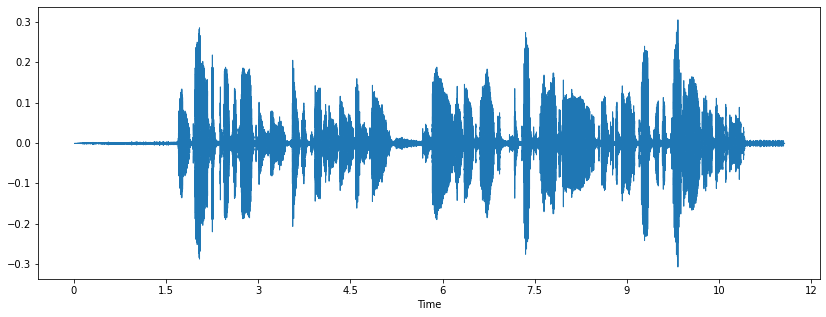

In [ ]:
# viz
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

In [ ]:
import IPython.display as ipd
ipd.Audio('audio.mp3')

In [ ]:
import whisper

model = whisper.load_model("base")

# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("audio.mp3")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Detected language: en
We study the capabilities of speech processing systems, trained simply to predict larger amounts of transcripts of audio on the Internet.


### evaluation on LibriSpeech

In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 35.5 MB/s 
     |████████████████████████████████| 2.2 MB 73.6 MB/s 


In [ ]:
# load dataset
# installing takes ~30 seconds
import os
import numpy as np

try:
    import tensorflow as tf  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.notebook import tqdm


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    MODIFIED: for white noise 
    """
    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000

        audio_clean = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel_c = whisper.log_mel_spectrogram(audio_clean)

        audio_noise = add_noise(audio.numpy(), sample_rate=sample_rate) # default white noise
        audio_noise = torch.from_numpy(audio_noise.astype('float32'))
        audio_noise = whisper.pad_or_trim(audio_noise.flatten()).to(self.device)
        mel_n = whisper.log_mel_spectrogram(audio_noise)

        audio_ds = down_sample(audio.numpy().flatten(), sample_rate=sample_rate) # default params
        audio_ds = torch.from_numpy(audio_ds.astype('float32'))
        audio_ds = whisper.pad_or_trim(audio_ds.flatten()).to(self.device)
        mel_d = whisper.log_mel_spectrogram(audio_ds)
        
        return (mel_c, mel_n, mel_d, text)
    
dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [ ]:
# load base model and review
model = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is English-only and has 71,825,408 parameters.


In [ ]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(language="en", without_timestamps=True, fp16 = False)

In [ ]:
# base model + 2619 samples will take 12 hours....
hypotheses_c = []
hypotheses_n = []
hypotheses_d = []
references = []

for i, (mels_c, mels_n, mels_d, texts) in enumerate(tqdm(loader)):
    results_c = model.decode(mels_c, options)
    hypotheses_c.extend([result.text for result in results_c])
    results_n = model.decode(mels_n, options)
    hypotheses_n.extend([result.text for result in results_n])
    results_d = model.decode(mels_d, options)
    hypotheses_d.extend([result.text for result in results_d])
    
    references.extend(texts)

  0%|          | 0/164 [00:00<?, ?it/s]

In [ ]:
# inspect on testing results
data_clean = pd.DataFrame(dict(hypothesis=hypotheses_c, reference=references))
data_noise = pd.DataFrame(dict(hypothesis=hypotheses_n, reference=references))
data_downs = pd.DataFrame(dict(hypothesis=hypotheses_d, reference=references))

,hypothesis,reference
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...
...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...


In [ ]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

def clean_text(normalizer, pred_dict):
  pred_dict["hypothesis_clean"] = [normalizer(text) for text in pred_dict["hypothesis"]]
  pred_dict["reference_clean"] = [normalizer(text) for text in pred_dict["reference"]]
  return(pred_dict)

normalizer = EnglishTextNormalizer()
data_clean = clean_text(normalizer, data_clean)
data_noise = clean_text(normalizer, data_noise)
data_downs = clean_text(normalizer, data_downs)

data_clean

,hypothesis,reference,hypothesis_clean,reference_clean
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM,stuffered into you his belly counseled him,stuff it into you his belly counseled him
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...,after early nightfall the yellow lamps would l...,after early nightfall the yellow lamps would l...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND,hello bertie any good in your mind,hello bertie any good in your mind
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...,number 10 fresh nelly is waiting on you good n...,number 10 fresh nelly is waiting on you good n...
...,...,...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...,0 to shoot my soul is full meaning into future...,0 to shoot my soul is full meaning into future...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...,then i long tried by natural ills received the...,then i long tried by natural ills received the...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...,i love thee freely as men strive for right i l...,i love thee freely as men strive for right i l...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...,i love thee with the passion put to use in my ...,i love thee with the passion put to use in my ...


In [ ]:
wer_c = jiwer.wer(list(data_clean["reference_clean"]), list(data_clean["hypothesis_clean"]))
wer_n = jiwer.wer(list(data_noise["reference_clean"]), list(data_noise["hypothesis_clean"]))
wer_d = jiwer.wer(list(data_downs["reference_clean"]), list(data_downs["hypothesis_clean"]))

print(f"Clean WER: {wer_c * 100:.2f} %")
print(f"White noise WER: {wer_n * 100:.2f} %")
print(f"Downsampled WER: {wer_d * 100:.2f} %")

WER: 4.26 %
